# Projeto: Determinação do Risco de Doença Cardiovascular

## Utilização de classificadores para indicar o risco de morte por doença cardiovascular com base em fatores de alto risco.



In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#import pandera as pa
from sklearn import preprocessing
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 
#from sklearn.decomposition import RandomizedPCA

from imblearn.over_sampling import SMOTENC

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm 

## Leitura dos dados 

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')#, sep=";", parse_dates=['ocorrencia_dia'], dayfirst=True)
#df.where(df['DEATH_EVENT']==0).head()
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Análise da correlação entre as variáveis da base de dados

<AxesSubplot:>

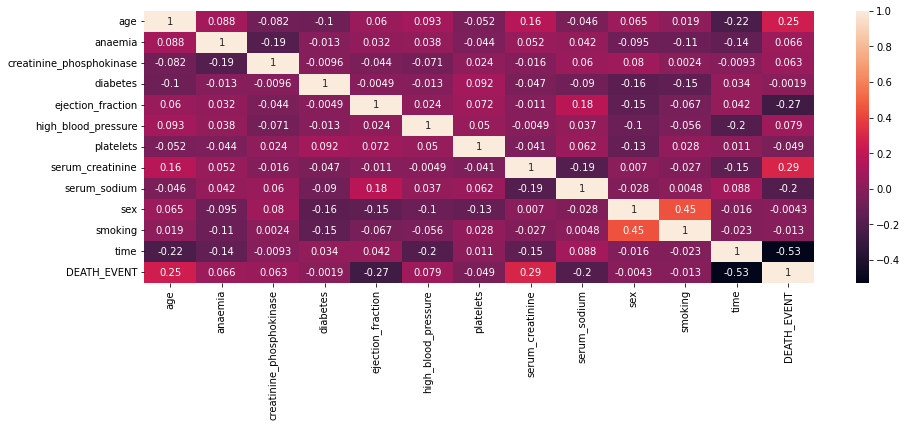

In [3]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(), annot=True)

<AxesSubplot:>

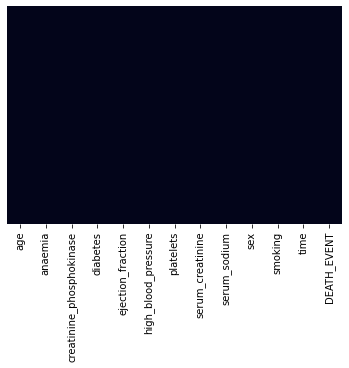

In [4]:
sns.heatmap(df.isnull(),cbar=False,yticklabels=False)

## Balanceando o dataset
Utilizando Minimax para ajustar os dados, balanceando entre 0 e 1

In [5]:
x = df.iloc[:, 0:12].copy()
y = df['DEATH_EVENT'].copy()

scaler = MinMaxScaler()
#scaler = StandardScaler()

#pca = PCA(n_components=6)

#%x[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']] = scaler.fit_transform(x[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']])
x[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']] = scaler.fit_transform(x[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']])

#sklearn.decomposition.RandomizedPCA
#pca = RandomizedPCA(n_components=6)
#x[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']] = pca.fit_transform(x[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']])

del x['sex']
del x['diabetes']
#del x['age']


## Removendo outliers
Utilizando o z-score para encontrar outliers

In [6]:
z_score = np.abs(stats.zscore(x))
location_of_outliers = np.where(z_score > 3)
x.drop(location_of_outliers[0], inplace = True)
y.drop(location_of_outliers[0], inplace = True)

In [7]:
#z_score
#type(new_x)

# configuracao melhor
#x_train, x_test, y_train, y_test = train_test_split(new_x, new_y, test_size = 0.2, random_state = 2)

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,smoking,time
0,1.192945,0.871105,0.000166,1.530560,1.359272,1.681648e-02,0.490057,1.504036,0.687682,1.629502
1,0.491279,0.871105,7.514640,0.007077,0.735688,7.535660e-09,0.284552,0.141976,0.687682,1.603691
2,0.350833,0.871105,0.449939,1.530560,0.735688,1.038073e+00,0.090900,1.731046,1.454161,1.590785
3,0.912335,1.147968,0.486071,1.530560,0.735688,5.464741e-01,0.490057,0.085034,0.687682,1.590785
4,0.350833,1.147968,0.435486,1.530560,0.735688,6.517986e-01,1.264666,4.682176,0.687682,1.577879
...,...,...,...,...,...,...,...,...,...,...
294,0.098199,0.871105,0.537688,0.007077,1.359272,1.109765e+00,0.284552,1.447094,1.454161,1.803451
295,0.491279,0.871105,1.278215,0.007077,0.735688,6.802472e-02,0.187726,0.539054,0.687682,1.816357
296,1.333392,0.871105,1.525979,1.854958,0.735688,4.902082e+00,0.575031,0.312044,0.687682,1.906697
297,1.333392,0.871105,1.890398,0.007077,0.735688,1.263389e+00,0.005926,0.766064,1.454161,1.932509


### Utilização da biblioteca SMOTENC para equilibrar a quantidade de dados para determinadas classes

In [8]:
# melhor
#random_forest = RandomForestClassifier(max_depth=10, random_state=5, criterion='gini')

new_x, new_y = SMOTENC(categorical_features=[1,4,8]).fit_resample(x, y)

#new_x, new_y = x, y

#x_train, x_test, y_train, y_test = train_test_split(new_x, new_y, test_size = 0.3, random_state = 1)
#X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.25, random_state=1)

#X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(new_x,new_y, 
                                                                            #method='sorted', sort_by_col='saledate',
                                                                           # train_size=0.8, valid_size=0.1, test_size=0.1)


#x_train, x_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.15, random_state=1)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.18, random_state=1) 
#70% 15% 15%

#x_train, x_test, y_train, y_test = train_test_split(new_x, new_y, test_size = 0.3, random_state = 1)
#70% 30%

#print(x_train.shape)
#print(y_train.shape)
#print(x_test.shape)

### Divisão dos dados de treino e dados de teste
Dados divididos entre 70% para treinamento e 30% para teste

In [28]:
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y, test_size = 0.3, random_state = 1)

### Definição do modelo do classificador Random Forest

In [51]:
random_forest = RandomForestClassifier(max_depth=8, random_state=1, criterion='gini')#, max_leaf_nodes=25, max_terminal_nodes=2)

### Validando o modelo com a estratégia K-fold, usando k=10

In [52]:
k=10
#kf = KFold(n_splits=k, random_state=5, shuffle=True)
kf = KFold(n_splits=k, random_state=None, shuffle=False)
X_kf = x_train.copy()
y_kf = y_train.copy()
acc_score = []
for train_index, test_index in kf.split(X_kf):#80% 20%
    Xkf_train, Xkf_test = X_kf.iloc[train_index,:], X_kf.iloc[test_index,:]
    #print(len(test_index))
    #print(y_kf)
    y_kf_train = y_kf.iloc[train_index]
    y_kf_test = y_kf.iloc[test_index]
    random_forest.fit(Xkf_train, y_kf_train)
    pred_values = random_forest.predict(Xkf_test)
    acc = accuracy_score(pred_values , y_kf_test)
    acc_score.append(acc)
avg_acc_score = sum(acc_score)/k

print('Acurácia de cada vold fold — {}'.format(acc_score))
print(f'Acurácia média para k={k} : {avg_acc_score*100}%')

Acurácia de cada vold fold — [0.8571428571428571, 0.7407407407407407, 0.8518518518518519, 0.9629629629629629, 0.8518518518518519, 0.9259259259259259, 0.9259259259259259, 0.8148148148148148, 0.8888888888888888, 0.8148148148148148]
Acurácia média para k=10 : 86.34920634920634%


### Treinando o modelo

In [31]:
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y, test_size = 0.3, random_state = 1)
random_forest = RandomForestClassifier(max_depth=8, random_state=1, criterion='gini')#, max_leaf_nodes=25, max_terminal_nodes=2)
random_forest.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, random_state=1)

### Testando o modelo

In [32]:
y_predicted = random_forest.predict(x_test)

### Métricas de Avaliaçao

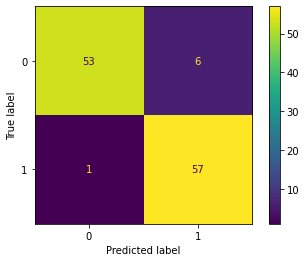

In [33]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_predicted, labels=random_forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=random_forest.classes_)
disp.plot()

In [14]:
len(y_test)-sum(y_test) # Number EVENT_DEATH = FALSE

59

In [34]:
Accuracy = accuracy_score(y_test, y_predicted)
print(f"Accuracy {Accuracy}%: ")
#print(accuracy_score(y_train, random_forest.predict(x_train)))
print(f'Recall: {recall_score(y_test, y_predicted)}')
print(f'Precision: {precision_score(y_test, y_predicted)}')
print(f'f1-score: {f1_score(y_test, y_predicted)}')

Accuracy 0.9401709401709402%: 
Recall: 0.9827586206896551
Precision: 0.9047619047619048
f1-score: 0.9421487603305785


# Testando outros classificadores

## MLP Classifier

Accuracy :  0.8974358974358975
Recall: 0.896551724137931
Precision: 0.896551724137931
f1-score: 0.896551724137931


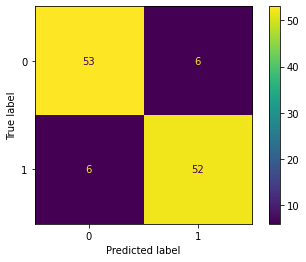

In [35]:
#Definindo o modelo
clf = MLPClassifier(random_state=1, max_iter=3000, hidden_layer_sizes=(2000,10),
                    activation='relu', solver='adam')

#Treinando o modelo
clf.fit(x_train, y_train)

#Testando o modelo
y_predicted_mlp = clf.predict(x_test)
accuracy_mlp = accuracy_score(y_test, y_predicted_mlp)
print("Accuracy : ",accuracy_mlp)
#print(f'Acuracia: {clf.score(x_test, y_test)}')
print(f'Recall: {recall_score(y_test, y_predicted_mlp)}')
print(f'Precision: {precision_score(y_test, y_predicted_mlp)}')
print(f'f1-score: {f1_score(y_test, y_predicted_mlp)}')

cm = confusion_matrix(y_test, y_predicted_mlp, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=clf.classes_)
disp.plot()

## KNN classifier

Accuracy :  0.8290598290598291
Recall: 0.7931034482758621
Precision: 0.8518518518518519
f1-score: 0.8214285714285715


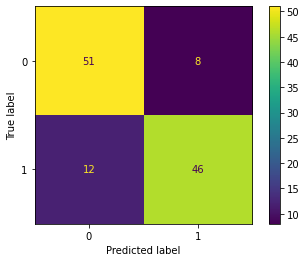

In [49]:
knn = KNeighborsClassifier(n_neighbors=4, algorithm='kd_tree',weights= 'distance')
knn.fit(x_train.values,y_train)
#Testes
y_predicted_knn = knn.predict(x_test.values)

accuracy_mlp = accuracy_score(y_test, y_predicted_knn)
print("Accuracy : ",accuracy_mlp)
print(f'Recall: {recall_score(y_test, y_predicted_knn)}')
print(f'Precision: {precision_score(y_test, y_predicted_knn)}')
print(f'f1-score: {f1_score(y_test, y_predicted_knn)}')

cm = confusion_matrix(y_test, y_predicted_knn, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=knn.classes_)
disp.plot()

## SVM Classifier

Accuracy :  0.8205128205128205
Recall: 0.8103448275862069
Precision: 0.8245614035087719
f1-score: 0.8173913043478261


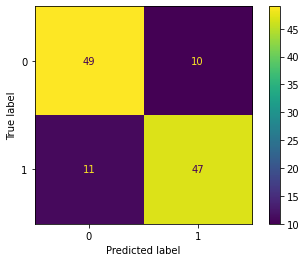

In [50]:
svm_model = svm.SVC(random_state=1, gamma='scale', kernel='rbf')
#treino
svm_model.fit(x_train, y_train)
y_predicted_svm = svm_model.predict(x_test)

accuracy_svm = accuracy_score(y_test, y_predicted_svm)

print("Accuracy : ", accuracy_svm)
print(f'Recall: {recall_score(y_test, y_predicted_svm)}')
print(f'Precision: {precision_score(y_test, y_predicted_svm)}')
print(f'f1-score: {f1_score(y_test, y_predicted_svm)}')

cm = confusion_matrix(y_test, y_predicted_svm, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=knn.classes_)
disp.plot()